# Experiments on KuHar Resampled to 20Hz

This notebook will perform basic experiments on the balanced KuHar dataset with the following steps:
1. Quick load train, test and validation CSV subsets from the balanced KuHar dataset using `PandasDatasetsIO` helper
2. Subclassing the `Dataset` interface using `PandasMultiModalDataset`
3. Apply the fourier transform on the dataset
4. Train and evaluate SVM, KNN and Random Forest classification models in the frequency domain, removing high frequencies from gyroscope. Train models by entering range of features (eg 0 to 1Hz, 0 to 2Hz, ..., 0 to 10Hz) and compare performances when adding high frequencies.

The experiments will evaluate the performance of SVM, KNN and RF models on the balanced KuHar dataset in both time and frequency domains.

## Common imports and definitions

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package

# This must be done if librep is not installed via pip,
# as this directory (examples) is appart from librep package root
sys.path.append("../../..")

# Third party imports
import pandas as pd
import numpy as np

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset # Wrap CSVs to librep's `Dataset` interface
from librep.datasets.har.loaders import KuHar_BalancedView20HzMotionSenseEquivalent

2022-10-10 16:56:05.895593: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 16:56:05.895613: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading data

In [2]:
loader = KuHar_BalancedView20HzMotionSenseEquivalent(
    root_dir="../../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1",
    download=False)

In [3]:
train_val, test = loader.load(concat_train_validation=True, label=loader.standard_label)
train_val

PandasMultiModalDataset: samples=3114, features=360, no. window=6, label_columns='standard activity code'

In [4]:
train_val.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,standard activity code
0,-1.042828,7.069610,3.455672,0.858443,-13.806092,-5.950121,-0.608514,2.916913,4.881929,8.610287,...,9.159,9.160,12.199,12.201,0,300,23,900,1101,4
1,-2.437900,-2.628449,-2.166861,-3.854701,0.527599,11.567884,6.840191,-2.435600,-3.324599,-0.796095,...,9.167,9.166,12.211,12.208,0,300,43,900,1101,4
2,-0.664337,0.483465,3.090238,3.559119,3.888318,1.113559,3.656104,4.866379,0.073993,-14.136122,...,15.262,15.263,18.298,18.299,0,300,24,1500,1101,4
3,-2.269775,-3.209509,-2.508545,-2.923223,-1.269270,7.864898,7.683389,2.325797,-3.086381,-3.675483,...,33.572,33.583,36.615,36.626,0,300,41,3300,1101,4
4,-0.487718,0.226401,0.609332,1.490074,-0.295221,-1.111420,-0.627382,0.028419,-0.823724,-0.469242,...,0.008,0.007,3.047,3.048,0,300,30,0,1101,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,-16.047706,-10.232285,-1.393564,22.982999,13.706479,7.789294,-4.720361,-15.633462,-8.674399,-11.634360,...,3.000,3.007,6.000,6.008,5,300,8,300,1042,5
3110,1.911780,-6.910686,1.625745,12.975344,12.066726,5.300426,-10.848059,-14.261385,-3.988711,-4.235381,...,5.927,5.927,8.880,8.879,5,300,2,600,1046,5
3111,3.927244,19.311380,0.403673,-14.236972,-10.454149,-4.218160,-4.307016,17.655546,12.570647,7.031853,...,2.966,2.966,5.920,5.919,5,300,5,300,1046,5
3112,-7.208894,-11.734247,13.677432,21.571222,3.191808,2.215446,-12.397302,-13.905091,-8.743007,11.580156,...,3.003,3.001,5.993,5.991,5,300,6,300,1042,5


In [5]:
train_val.data.iloc[:,:180]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,accel-z-50,accel-z-51,accel-z-52,accel-z-53,accel-z-54,accel-z-55,accel-z-56,accel-z-57,accel-z-58,accel-z-59
0,-1.042828,7.069610,3.455672,0.858443,-13.806092,-5.950121,-0.608514,2.916913,4.881929,8.610287,...,1.203877,-2.067140,0.599362,0.798184,0.373408,0.863658,2.250888,1.490413,-3.197400,-5.812320
1,-2.437900,-2.628449,-2.166861,-3.854701,0.527599,11.567884,6.840191,-2.435600,-3.324599,-0.796095,...,0.049406,-5.541965,-0.970365,1.136995,-0.425824,0.526326,-0.745246,2.276487,0.830371,0.503386
2,-0.664337,0.483465,3.090238,3.559119,3.888318,1.113559,3.656104,4.866379,0.073993,-14.136122,...,-3.725977,-1.894624,-1.025737,-0.665650,-0.624930,0.945823,0.167892,1.352055,1.469390,0.855615
3,-2.269775,-3.209509,-2.508545,-2.923223,-1.269270,7.864898,7.683389,2.325797,-3.086381,-3.675483,...,-0.512601,-0.560058,-0.688911,-0.593756,-0.920183,-0.214201,-0.537406,-0.798943,-1.301604,0.014319
4,-0.487718,0.226401,0.609332,1.490074,-0.295221,-1.111420,-0.627382,0.028419,-0.823724,-0.469242,...,0.035364,-5.264918,-1.190147,0.858956,0.788779,0.043240,1.241758,1.265771,1.842072,1.489244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,-16.047706,-10.232285,-1.393564,22.982999,13.706479,7.789294,-4.720361,-15.633462,-8.674399,-11.634360,...,5.194928,6.785204,-7.913086,5.151192,1.538744,-15.721545,21.028758,4.176134,4.768997,5.601646
3110,1.911780,-6.910686,1.625745,12.975344,12.066726,5.300426,-10.848059,-14.261385,-3.988711,-4.235381,...,-1.807432,0.501866,-10.251513,5.379480,0.492609,3.000820,-2.558241,-3.493139,-1.838372,-3.222727
3111,3.927244,19.311380,0.403673,-14.236972,-10.454149,-4.218160,-4.307016,17.655546,12.570647,7.031853,...,7.026263,1.648933,4.677450,-5.099783,-5.919384,0.372033,-4.834223,-0.002274,5.750979,4.629065
3112,-7.208894,-11.734247,13.677432,21.571222,3.191808,2.215446,-12.397302,-13.905091,-8.743007,11.580156,...,4.961487,7.688895,-4.400769,1.979515,-2.421602,4.875791,10.093376,3.467338,12.325461,-4.190265


In [6]:
train_val.data.iloc[:,180:-10]

,gyro-x-0,gyro-x-1,gyro-x-2,gyro-x-3,gyro-x-4,gyro-x-5,gyro-x-6,gyro-x-7,gyro-x-8,gyro-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,1.011193,-0.135713,-0.187018,-1.230379,-0.145241,-0.715555,-0.200176,0.122528,0.423914,0.300850,...,-0.472805,0.343294,0.260441,-0.082865,0.299246,0.215924,0.322555,0.508903,-0.113054,-0.380190
1,-0.364706,-0.077461,0.131981,-0.013006,-0.266993,-0.124421,-0.200418,-0.100503,-0.170458,-0.113543,...,0.267483,-0.713088,0.337778,-0.016247,-0.170998,0.067450,-0.153206,-0.094137,-0.238300,0.377260
2,-0.484002,0.190188,0.258668,0.372277,0.055248,0.109123,-0.361042,0.381032,0.377186,0.048870,...,0.371043,0.478258,-0.547497,-0.010739,0.005712,-0.275884,0.048012,0.288451,0.118925,0.288595
3,0.081890,-0.359278,-0.104397,0.125346,-0.175288,0.000082,-0.083572,0.339405,0.307220,0.175300,...,0.011855,0.110627,0.131676,0.085040,0.143971,0.129493,0.189543,0.057577,-0.121568,-0.037776
4,0.471796,0.354504,0.014312,0.142590,0.123235,-0.139595,-0.441911,-0.190417,-0.103427,-0.212313,...,-0.224966,0.039142,-0.232840,0.027406,-0.153478,-0.047371,0.020793,0.186724,0.132858,0.318369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,0.116109,0.255309,-0.585907,-0.149230,-1.363154,0.162033,0.517974,0.405179,0.794959,0.742731,...,-0.110008,1.042713,-1.098746,-0.203113,0.062445,0.489244,-0.153889,-0.825626,1.408920,-0.048886
3110,0.637848,-0.501481,0.322876,0.608003,-0.719195,0.266452,1.585102,-0.277814,0.251531,0.813899,...,-0.255121,0.348626,1.796430,-0.504031,-0.271142,-0.141103,-0.355877,0.450288,-0.041400,-0.955341
3111,0.409374,-0.972838,0.818263,1.451386,-0.669391,0.353621,1.409431,-1.285197,1.576491,-0.771403,...,-0.825732,-0.816069,-0.332729,-0.034519,0.551195,-0.635052,-1.169866,0.926100,1.036354,-0.090644
3112,0.162547,0.479668,0.618632,-0.981451,0.016352,-0.381085,-1.168045,0.628960,-0.353749,-0.173399,...,0.261531,1.145154,-0.355114,1.075646,-1.983060,-1.722173,2.191585,-0.139135,0.742427,0.765420


In [7]:
train_val.data['standard activity code']

0       4
1       4
2       4
3       4
4       4
       ..
3109    5
3110    5
3111    5
3112    5
3113    5
Name: standard activity code, Length: 3114, dtype: int64

## Creating a Librep dataset from pandas dataframes

In [8]:
train_val_acc = np.array(train_val.data.iloc[:,:180])
test_acc = np.array(test.data.iloc[:,:180])

train_val_gyr = np.array(train_val.data.iloc[:,180:-10])
test_gyr = np.array(test.data.iloc[:,180:-10])

train_y = np.array(train_val.data['standard activity code'])
test_y = np.array(test.data['standard activity code'])

In [9]:
import pandas as pd

# Accelerometer
train_acc = pd.DataFrame(train_val_acc,columns=train_val.data.iloc[:,:180].columns)
train_acc['standard activity code'] = train_val.data['standard activity code']

test_acc = pd.DataFrame(test_acc,columns=test.data.iloc[:,:180].columns)
test_acc['standard activity code'] = test.data['standard activity code']

# Gyroscope
train_gyr = pd.DataFrame(train_val_gyr,columns=train_val.data.iloc[:,180:-10].columns)
train_gyr['standard activity code'] = train_val.data['standard activity code']

test_gyr = pd.DataFrame(test_gyr,columns=test.data.iloc[:,180:-10].columns)
test_gyr['standard activity code'] = test.data['standard activity code']

In [10]:
train_acc

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,accel-z-51,accel-z-52,accel-z-53,accel-z-54,accel-z-55,accel-z-56,accel-z-57,accel-z-58,accel-z-59,standard activity code
0,-1.042828,7.069610,3.455672,0.858443,-13.806092,-5.950121,-0.608514,2.916913,4.881929,8.610287,...,-2.067140,0.599362,0.798184,0.373408,0.863658,2.250888,1.490413,-3.197400,-5.812320,4
1,-2.437900,-2.628449,-2.166861,-3.854701,0.527599,11.567884,6.840191,-2.435600,-3.324599,-0.796095,...,-5.541965,-0.970365,1.136995,-0.425824,0.526326,-0.745246,2.276487,0.830371,0.503386,4
2,-0.664337,0.483465,3.090238,3.559119,3.888318,1.113559,3.656104,4.866379,0.073993,-14.136122,...,-1.894624,-1.025737,-0.665650,-0.624930,0.945823,0.167892,1.352055,1.469390,0.855615,4
3,-2.269775,-3.209509,-2.508545,-2.923223,-1.269270,7.864898,7.683389,2.325797,-3.086381,-3.675483,...,-0.560058,-0.688911,-0.593756,-0.920183,-0.214201,-0.537406,-0.798943,-1.301604,0.014319,4
4,-0.487718,0.226401,0.609332,1.490074,-0.295221,-1.111420,-0.627382,0.028419,-0.823724,-0.469242,...,-5.264918,-1.190147,0.858956,0.788779,0.043240,1.241758,1.265771,1.842072,1.489244,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,-16.047706,-10.232285,-1.393564,22.982999,13.706479,7.789294,-4.720361,-15.633462,-8.674399,-11.634360,...,6.785204,-7.913086,5.151192,1.538744,-15.721545,21.028758,4.176134,4.768997,5.601646,5
3110,1.911780,-6.910686,1.625745,12.975344,12.066726,5.300426,-10.848059,-14.261385,-3.988711,-4.235381,...,0.501866,-10.251513,5.379480,0.492609,3.000820,-2.558241,-3.493139,-1.838372,-3.222727,5
3111,3.927244,19.311380,0.403673,-14.236972,-10.454149,-4.218160,-4.307016,17.655546,12.570647,7.031853,...,1.648933,4.677450,-5.099783,-5.919384,0.372033,-4.834223,-0.002274,5.750979,4.629065,5
3112,-7.208894,-11.734247,13.677432,21.571222,3.191808,2.215446,-12.397302,-13.905091,-8.743007,11.580156,...,7.688895,-4.400769,1.979515,-2.421602,4.875791,10.093376,3.467338,12.325461,-4.190265,5


In [11]:
# Kuhar features to select

features_acc = [
    "accel-x",
    "accel-y",
    "accel-z"
]

# Creating the datasets

# Train
train_dataset_acc = PandasMultiModalDataset(
    train_acc,
    feature_prefixes=features_acc,
    label_columns='standard activity code',
    as_array=True
)

# Test
test_dataset_acc = PandasMultiModalDataset(
    test_acc,
    feature_prefixes=features_acc,
    label_columns='standard activity code',
    as_array=True
)

In [12]:
# Kuhar features to select

features_gyr = [
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_dataset_gyr = PandasMultiModalDataset(
    train_gyr,
    feature_prefixes=features_gyr,
    label_columns='standard activity code',
    as_array=True
)

# Test
test_dataset_gyr = PandasMultiModalDataset(
    test_gyr,
    feature_prefixes=features_gyr,
    label_columns='standard activity code',
    as_array=True
)

## Fourier Transform

In [13]:
from librep.datasets.multimodal import TransformMultiModalDataset
from librep.transforms.fft import FFT

In [14]:
fft_transform = FFT(centered = True)
transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")

### Use FFT in Kuhar

In [15]:
from librep.datasets.multimodal.multimodal import ArrayMultiModalDataset
from librep.transforms.removeFrequencies import RemoveFrequencies

fs_cut = 10
train_fft_acc = transformer(train_dataset_acc)
test_fft_acc = transformer(test_dataset_acc)

train_fft_gyr = transformer(train_dataset_gyr)
test_fft_gyr = transformer(test_dataset_gyr)

num_windows = train_fft_acc.num_windows # It's equal the number of sensors
num_per_slices = train_fft_acc.window_slices[0][1] # It's equal the number of features for sensor
num_per_frequency = num_per_slices // fs_cut

## Train and evaluate Random Forest classifier

In [16]:
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier
from librep.metrics.report import ClassificationReport
import yaml

reporter = ClassificationReport(use_accuracy=True, use_f1_score=True, use_classification_report=False, use_confusion_matrix=False, plot_confusion_matrix=False)
experiment = SimpleTrainEvalWorkflow(estimator=RandomForestClassifier, estimator_creation_kwags ={'n_estimators':100} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

In [17]:
from librep.datasets.multimodal import combine_multi_modal_datasets

results_rf = []

k = 0
while(k <= fs_cut):
    frequencies_to_remove = [i for i in range(k*num_per_frequency, fs_cut*num_per_frequency)]

    frequencies_transform = RemoveFrequencies(interval=frequencies_to_remove)
    transformer = TransformMultiModalDataset(transforms=[frequencies_transform])

    train_fft_acc_reduced = transformer(train_fft_acc)
    test_fft_acc_reduced = transformer(test_fft_acc)
    
    train_fft_reduced = combine_multi_modal_datasets(train_fft_acc_reduced, train_fft_gyr)
    test_fft_reduced = combine_multi_modal_datasets(test_fft_acc_reduced, test_fft_gyr)
    
    result = multi_run_experiment(train_fft_reduced, test_fft_reduced)
    results_rf.append(result)
    print('Iteração: ', k+1)
    k+=1

Iteração:  1
Iteração:  2
Iteração:  3
Iteração:  4
Iteração:  5
Iteração:  6
Iteração:  7
Iteração:  8
Iteração:  9
Iteração:  10
Iteração:  11


## Train and evaluate Support Vector Machine classifier

In [18]:
from librep.estimators import SVC

experiment = SimpleTrainEvalWorkflow(estimator=SVC, estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

results_svc = []
k = 0
while(k <= fs_cut):
    frequencies_to_remove = [i for i in range(k*num_per_frequency, fs_cut*num_per_frequency)]

    frequencies_transform = RemoveFrequencies(interval=frequencies_to_remove)
    transformer = TransformMultiModalDataset(transforms=[frequencies_transform])

    train_fft_acc_reduced = transformer(train_fft_acc)
    test_fft_acc_reduced = transformer(test_fft_acc)
    
    train_fft_reduced = combine_multi_modal_datasets(train_fft_acc_reduced, train_fft_gyr)
    test_fft_reduced = combine_multi_modal_datasets(test_fft_acc_reduced, test_fft_gyr)

    result = multi_run_experiment(train_fft_reduced, test_fft_reduced)
    results_svc.append(result)
    print('Iteração: ', k+1)
    k+=1

Iteração:  1
Iteração:  2
Iteração:  3
Iteração:  4
Iteração:  5
Iteração:  6
Iteração:  7
Iteração:  8
Iteração:  9
Iteração:  10
Iteração:  11


## Train and evaluate K Neighbors Classifier classifier

In [19]:
from librep.estimators import KNeighborsClassifier

experiment = SimpleTrainEvalWorkflow(estimator=KNeighborsClassifier, estimator_creation_kwags ={'n_neighbors' :1} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)

results_knn = []
k = 0
while(k <= fs_cut):
    frequencies_to_remove = [i for i in range(k*num_per_frequency, fs_cut*num_per_frequency)]

    frequencies_transform = RemoveFrequencies(interval=frequencies_to_remove)
    transformer = TransformMultiModalDataset(transforms=[frequencies_transform])

    train_fft_acc_reduced = transformer(train_fft_acc)
    test_fft_acc_reduced = transformer(test_fft_acc)
    
    train_fft_reduced = combine_multi_modal_datasets(train_fft_acc_reduced, train_fft_gyr)
    test_fft_reduced = combine_multi_modal_datasets(test_fft_acc_reduced, test_fft_gyr)
    
    result = multi_run_experiment(train_fft_reduced, test_fft_reduced)
    results_knn.append(result)
    print('Iteração: ', k+1)
    k+=1

Iteração:  1
Iteração:  2
Iteração:  3
Iteração:  4
Iteração:  5
Iteração:  6
Iteração:  7
Iteração:  8
Iteração:  9
Iteração:  10
Iteração:  11


In [20]:
def chart(classifiers, metric, xlabel, title, fs_cut):
    X = ['[]']
    X += ['[{}, {}]'.format(0, i) for i in range(1, fs_cut+1)]
    for classifier in classifiers:
        plt.plot(X, classifiers[classifier][metric], label=classifier) 

    plt.xlabel(xlabel) 
    plt.ylabel(metric) 
    plt.title(title) 
    plt.xlim(0,fs_cut)
    plt.legend() 
    plt.grid()
    plt.show()

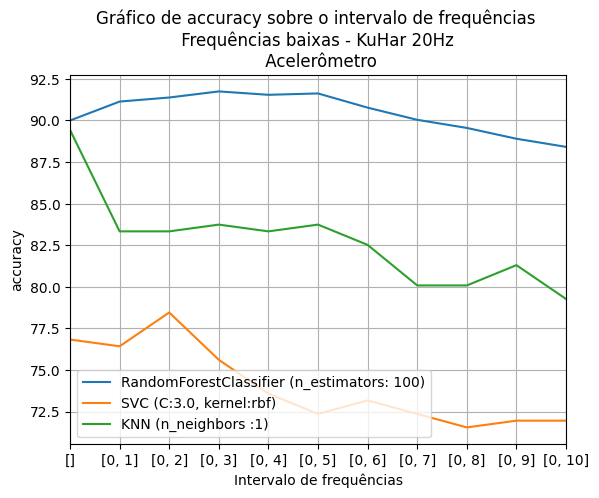

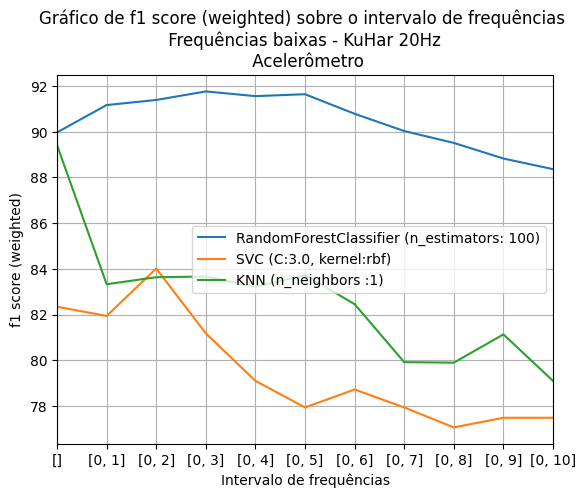

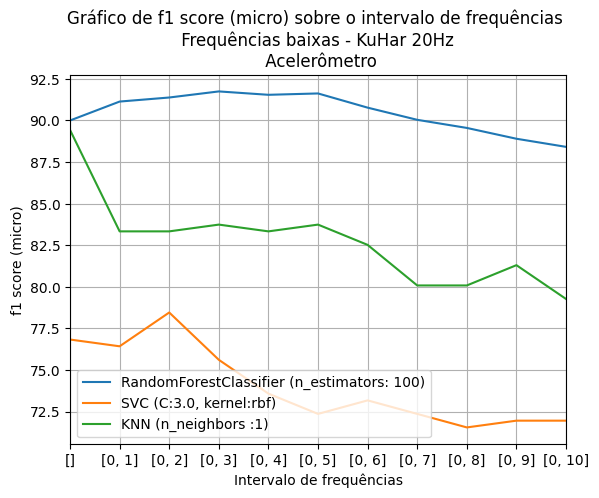

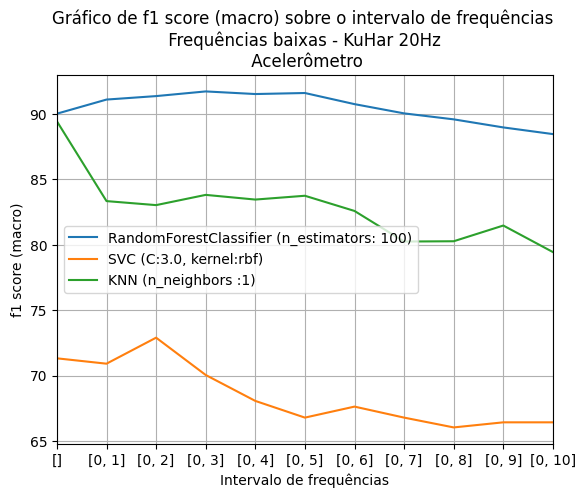

In [21]:
import matplotlib.pyplot as plt

metrics = ['accuracy', 'f1 score (weighted)', 'f1 score (micro)', 'f1 score (macro)']

scores_rf = {metric:[] for metric in metrics}
scores_rf_average = {metric:[] for metric in metrics}

scores_svc = {metric:[] for metric in metrics}
scores_svc_average = {metric:[] for metric in metrics}

scores_knn = {metric:[] for metric in metrics}
scores_knn_average = {metric:[] for metric in metrics}

for metric in metrics:
    for i in range(fs_cut+1):
            score_rf, score_svc, score_knn = [], [], []
            for j in range(10):
                value_rf = results_rf[i]['runs'][j]['result'][0][metric]
                score_rf.append(100*value_rf)

            value_svc = results_svc[i]['runs'][0]['result'][0][metric]
            score_svc.append(100*value_svc)

            value_knn = results_knn[i]['runs'][0]['result'][0][metric]
            score_knn.append(100*value_knn)

            scores_rf[metric].append(score_rf)
            scores_rf_average[metric].append(np.mean(score_rf))

            scores_svc[metric].append(score_svc)
            scores_svc_average[metric].append(np.mean(score_svc))

            scores_knn[metric].append(score_knn)
            scores_knn_average[metric].append(np.mean(score_knn))

classifiers = {
    'RandomForestClassifier (n_estimators: 100)' : scores_rf_average,
    'SVC (C:3.0, kernel:rbf)' : scores_svc_average,
    'KNN (n_neighbors :1)' : scores_knn_average
}
for metric in metrics:
    xlabel = "Intervalo de frequências"
    # ylabel = metric
    title = "Gráfico de {} sobre o intervalo de frequências \n Frequências baixas - KuHar {}Hz \n Acelerômetro".format(metric, 
                                                                                                    fs_cut*2)
    chart(classifiers, metric, xlabel, title, fs_cut)

In [22]:
import pickle

def inserirArquivo(result, geekyfile):

    try: 
        geeky_file = open(geekyfile, 'wb') 
        pickle.dump(result, geeky_file) 
        geeky_file.close() 

    except: 
        print("Something went wrong")

arq_name = 'KuHar_20Hz_removing_accelerometer_high_frequencies'
inserirArquivo(classifiers, arq_name)